# Cuestionario 2 - Aprendizaje automático

El desafío principal de este dataset (German Credit Data) es que el coste de no detectar a un moroso es mucho más alto que el de rechazar a un buen cliente. A lo largo del notebook, no solo buscaremos la precisión matemática, sino la rentabilidad del negocio.

Primero vamos a importar los modulos necesarios para la realización de la actividad.

In [21]:
# --- Standard Library Imports ---
import warnings

# --- Third-Party Imports (Data & Math) ---
import numpy as np
import pandas as pd

# --- Third-Party Imports (Visualization) ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Third-Party Imports (Machine Learning) ---
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
)

# --- Configuration ---
# Filter warnings to keep the output clean
warnings.filterwarnings('ignore')
# Set plot style for professional looking charts
sns.set_style("whitegrid")
# Display all columns in pandas
pd.set_option('display.max_columns', None)

Dado que el dataset original no define los nombres de sus columnas primero realizamos una lectura detallada del archivo german.doc para encontrar dichas etiquetas. Posteriormente hacemos la carga del dataset en un dataframe de pandas. Además haremos una comprobación de cuantos clientes buenos y malos hay para detectar si el dataset está desbalanceado.

In [22]:

nombres_columnas = [
    'Estado_Cuenta', 'Duración', 'Historial_Credito', 'Propósito', 'Cantidad_Credito',
    'Ahorros', 'Empleo_Desde', 'Tasa_Cuota', 'Estado_Sexo', 'Otros_Deudores', 
    'Residencia_Desde', 'Propiedad', 'Edad', 'Otros_Planes', 'Vivienda', 
    'Creditos_Existentes', 'Trabajo', 'Personas_Cargo', 'Telefono', 'Trabajador_Extranjero', 
    'Clase_Riesgo'
]

df = pd.read_csv('../data/german.data', sep=' ', names=nombres_columnas)
display(df.head())

conteo = df['Clase_Riesgo'].value_counts()
total = len(df)
pct_buenos = (conteo[1] / total) * 100
pct_malos = (conteo[2] / total) * 100

print(f"Total de clientes: {total}")
print(f"Clientes BUENOS (1): {conteo[1]} ({pct_buenos:.1f}%)")
print(f"Clientes MALOS (2):  {conteo[2]} ({pct_malos:.1f}%)")

,Estado_Cuenta,Duración,Historial_Credito,Propósito,Cantidad_Credito,Ahorros,Empleo_Desde,Tasa_Cuota,Estado_Sexo,Otros_Deudores,Residencia_Desde,Propiedad,Edad,Otros_Planes,Vivienda,Creditos_Existentes,Trabajo,Personas_Cargo,Telefono,Trabajador_Extranjero,Clase_Riesgo
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


Total de clientes: 1000
Clientes BUENOS (1): 700 (70.0%)
Clientes MALOS (2):  300 (30.0%)


Claramente esta desbalanceado, por tanto debemos tener cuidado con los resultado ya que diciendo siempre sí acertariamos en un 70% de los casos.

Vamos a comprobar el dataset, conteando la existencia de valores nulos por columna

In [23]:
print("\nConteo de valores nulos:")
print(df.isnull().sum())



Conteo de valores nulos:
Estado_Cuenta            0
Duración                 0
Historial_Credito        0
Propósito                0
Cantidad_Credito         0
Ahorros                  0
Empleo_Desde             0
Tasa_Cuota               0
Estado_Sexo              0
Otros_Deudores           0
Residencia_Desde         0
Propiedad                0
Edad                     0
Otros_Planes             0
Vivienda                 0
Creditos_Existentes      0
Trabajo                  0
Personas_Cargo           0
Telefono                 0
Trabajador_Extranjero    0
Clase_Riesgo             0
dtype: int64


Antes de entrenar, utilizamos técnicas visuales para entender las relaciones entre variables:
* **Mapa de Calor (Heatmap):** Para detectar correlaciones.
* **Matriz de Dispersión:** Para visualizar la distribución de los grupos de riesgo.

Como hemos comprobado este dataset no tiene valores nulos. Pero en cambio si tiene valores no numericos que nos impediran el análisis con coeficiente de pearson o con mapas de calor. Por ello vamos a seleccionar solo aquellas columnas con valores numericos.

<Axes: >

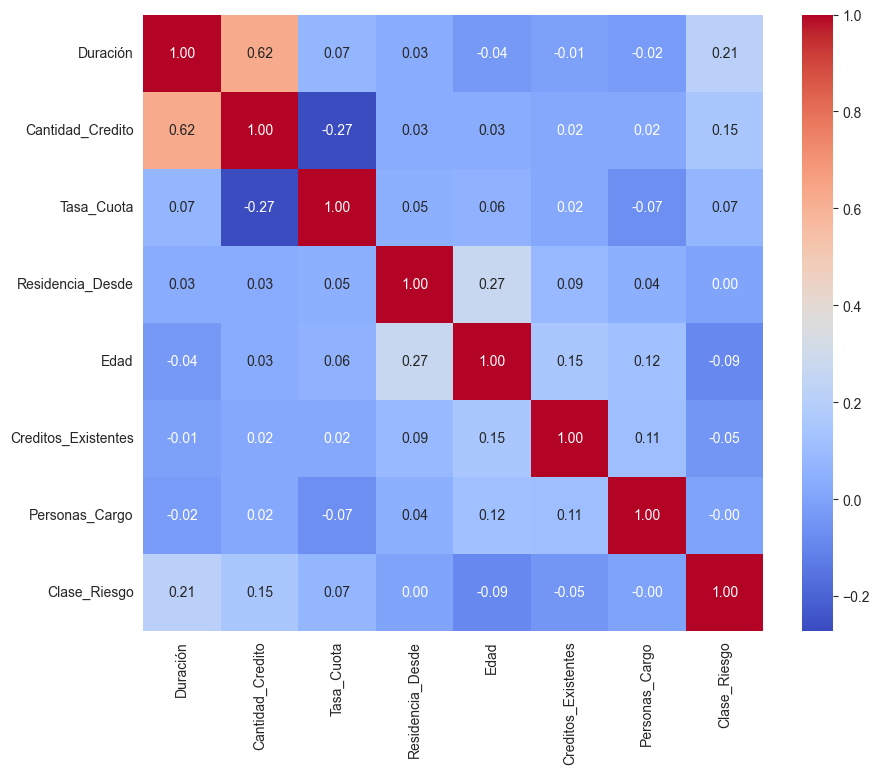

In [24]:
df_numeric = df.select_dtypes(include=[np.number])
matriz_correlacion = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, 
            annot=True,
            cmap='coolwarm',  
            fmt=".2f")    

Tras realizar el análisis de correlación de Pearson sobre las variables numéricas del conjunto de datos hemos seleccionado Duración, Cantidad_Crédito y Edad como las variables numéricas más relevantes. Esto se debe a que observando la última fila del heatmap hemos identificado cuales tienen más influencia en la Clase_Riesgo y hemos obtenido estas.

En este caso, dado que edad tiene un coeficiente de correlación negativo, nos indica que a mayor edad el riesgo decrece ligeramente.
Además aunque hemos detectado una fuerte coorrelación entre la Duración y la Cantidad_Credito, esta no es suficientemente alta como para poder obviar una de las dos.

Es decir, basándonos en el mapa de calor, el perfil de riesgo numérico parece definirse principalmente por cuánto dinero se pide y a cuánto tiempo, matizado ligeramente por la edad del solicitante

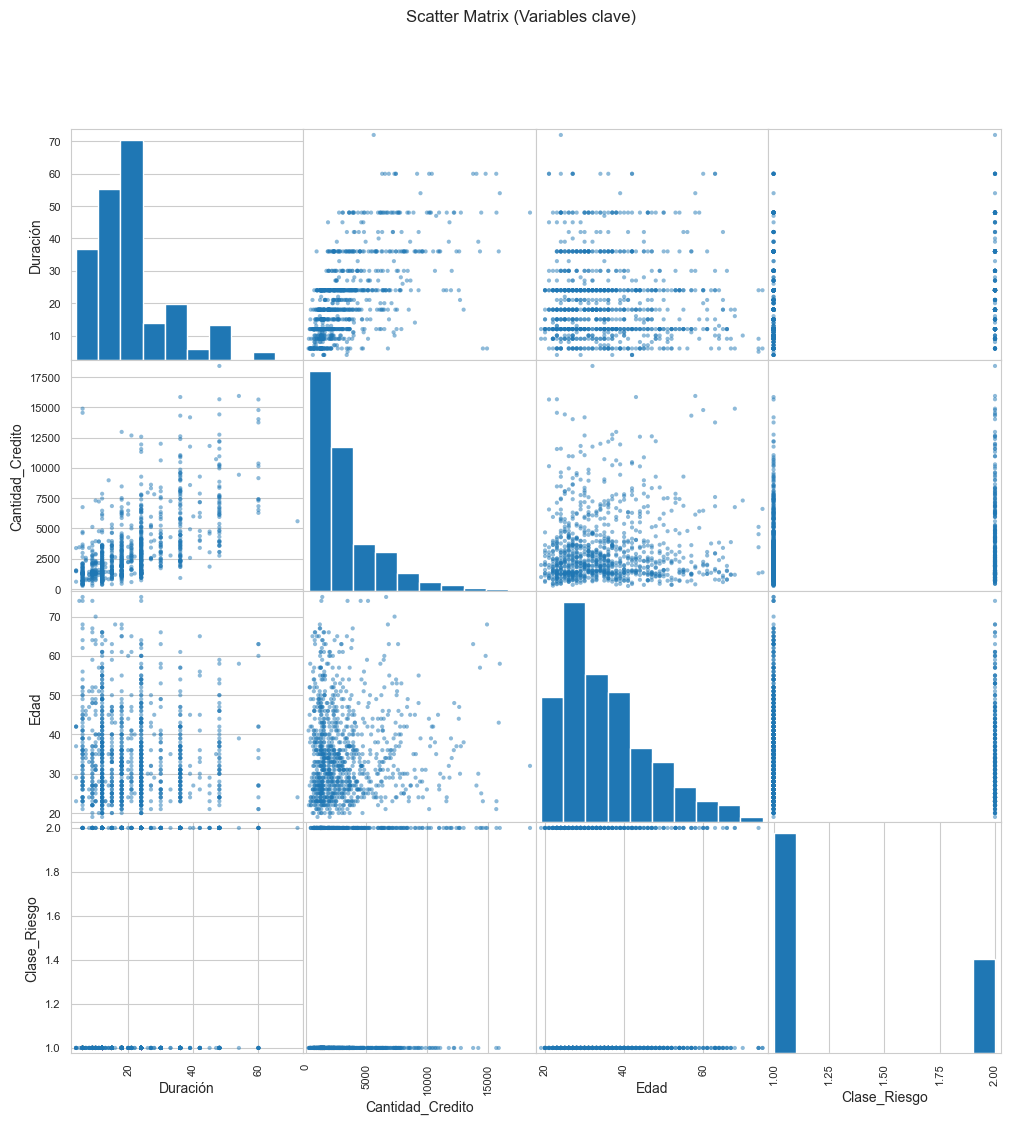

In [25]:
vars_interes = ['Duración', 'Cantidad_Credito', 'Edad', 'Clase_Riesgo']
pd.plotting.scatter_matrix(df[vars_interes], 
                           figsize=(12, 12),  
                           diagonal='hist',  
                           alpha=0.5)         

plt.suptitle("Scatter Matrix (Variables clave)")
plt.show()

Analicemos que significa, primero fijemonos en la diagonal. Tanto en duración como en cantidad de crédito y edad el grueso de los datos se encuentra a la izquierda lo que nos indica que estos se agrupan en valores bajos.

Además, si evaluamos el resto de casillas podremos deducir como interaccionan entre ellas. 

Primeramente, evaluando la casilla de duración y cantidad de crédito, podemos observar una estructura como de cono, es decir, si pides poco dinero, casi siempre es a poco tiempo. Pero si pides mucho dinero, el tiempo varía mucho más.

Podemos observar que no hay una relación clara entre edad y duración, más alla de que a mayor edad es menos posible pedir créditos muy largos.

Continuemos evaluando la casilla de edad y cantidad de crédito, en esta podemos observar que tanto los jovenes como las personas de más edad tienden a pedir créditos pequeños, no se observa una coorrelación clara. Podemos ver como casi no hay créditos grandes en edades avanzadas.

Por último evaluemos la última fila, el riesgo. A simple vista es dificil poder separar el riesgo alto del bajo, por ello nos es necesario seguir con el estudio.

# Entrenamiento del arbol de decisión

Dado que el modelo tiene variables categóricas, debemos encontrar alguna forma de tratar estos datos. Para ello vamos a realizar "One-hot" encoding. Transformaremos los distintos valores de la variable categórica en nuevas columnas que pueden tomar como valor 1 o 0 según si se cumplen o no respectivamente.

A continuación, dividimos los datos en:
* **Entrenamiento (70%):** Para que el modelo aprenda patrones.
* **Prueba (30%):** Para evaluar su rendimiento en datos desconocidos.

Limitaremos (inicialmente) la profundidad del árbol (max_depth=3) para que no se vuelva loco creando reglas infinitas y para que el dibujo sea legible.

In [26]:
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop('Clase_Riesgo', axis=1)
y = df['Clase_Riesgo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

arbol = DecisionTreeClassifier(max_depth=3, random_state=42)
arbol.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

Una vez obtenidos los conjuntos de entrenamiento y de prueba, pasemos a formar el arbol de decisión.

In [27]:
arbol = DecisionTreeClassifier(max_depth=3, random_state=42)
arbol.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

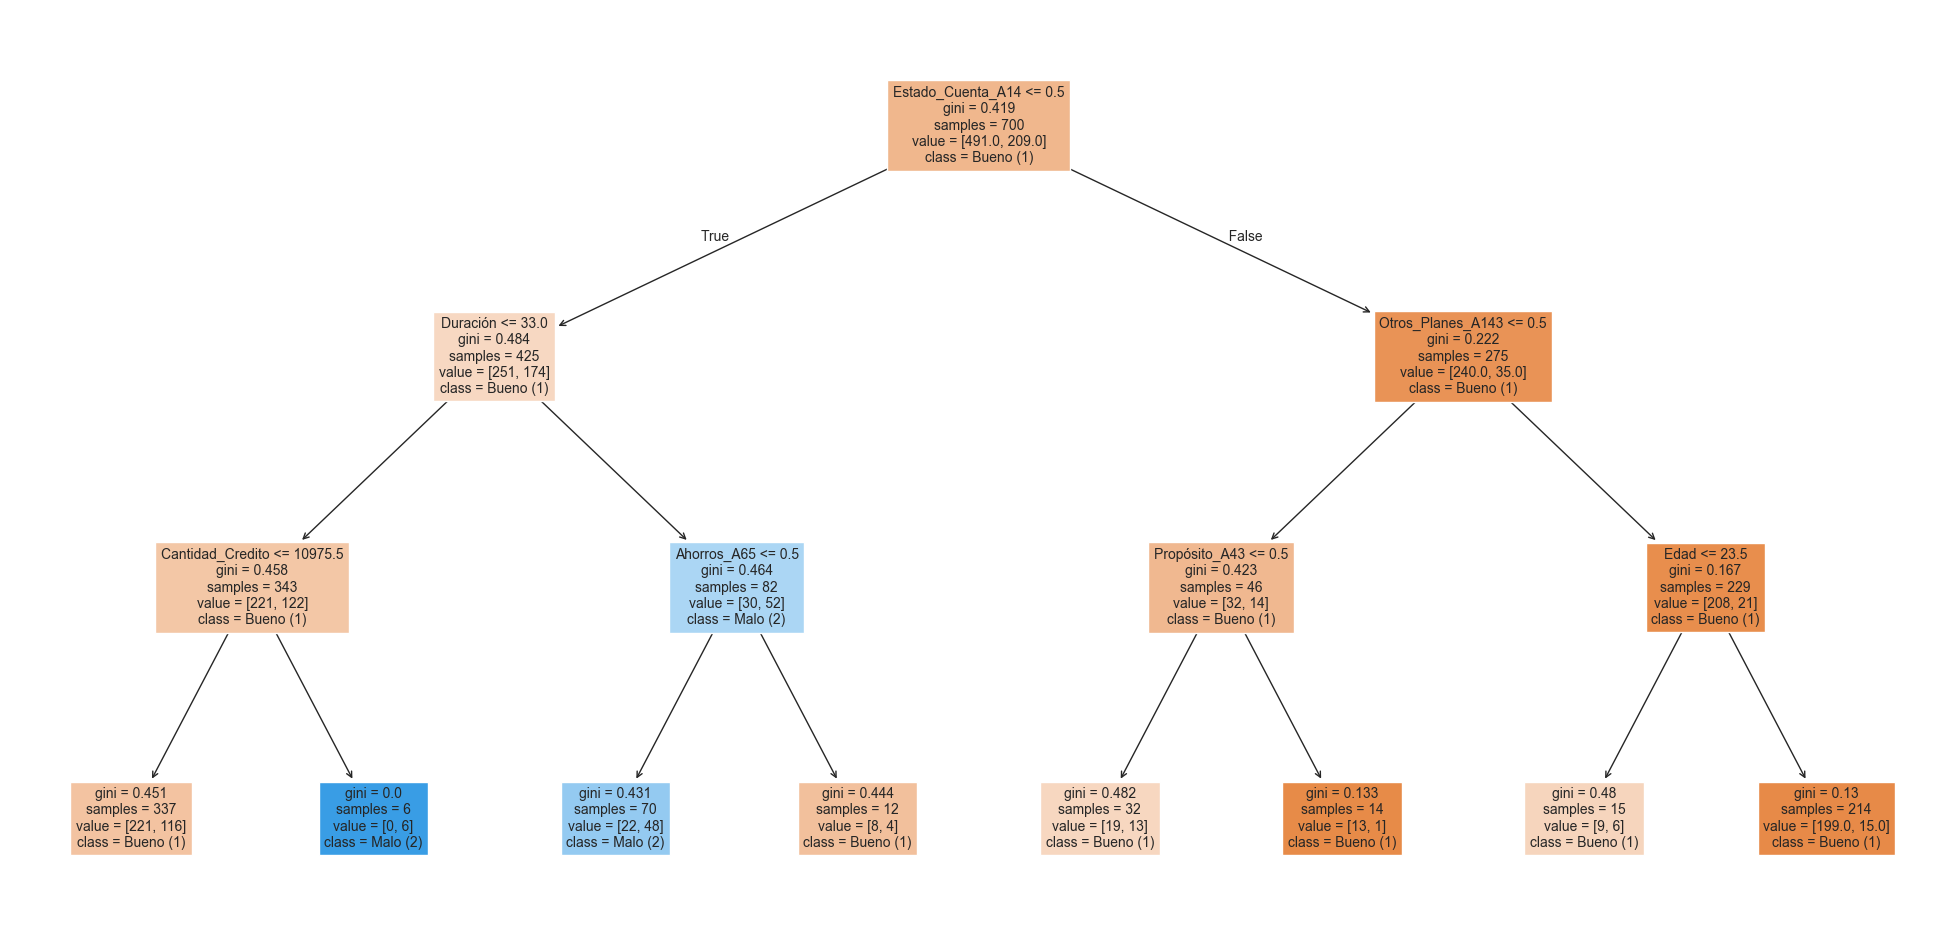

In [28]:
plt.figure(figsize=(25, 12))
plot_tree(arbol, 
          feature_names=X.columns,       
          class_names=['Bueno (1)', 'Malo (2)'], 
          filled=True,                 
          fontsize=10)                   

plt.show()

El análisis de importancia de características (feature_importances) nos revela que el la selección de variables implícita que realiza un arbol. Variables con peso de 0.0, lo que significa que el algoritmo las ha descartado por sí mismo al no considerarlas útiles para la clasificación. Aunque podríamos eliminarlas físicamente del dataset para limpiarlo, el resultado predictivo sería idéntico porque el modelo ya las está ignorando.

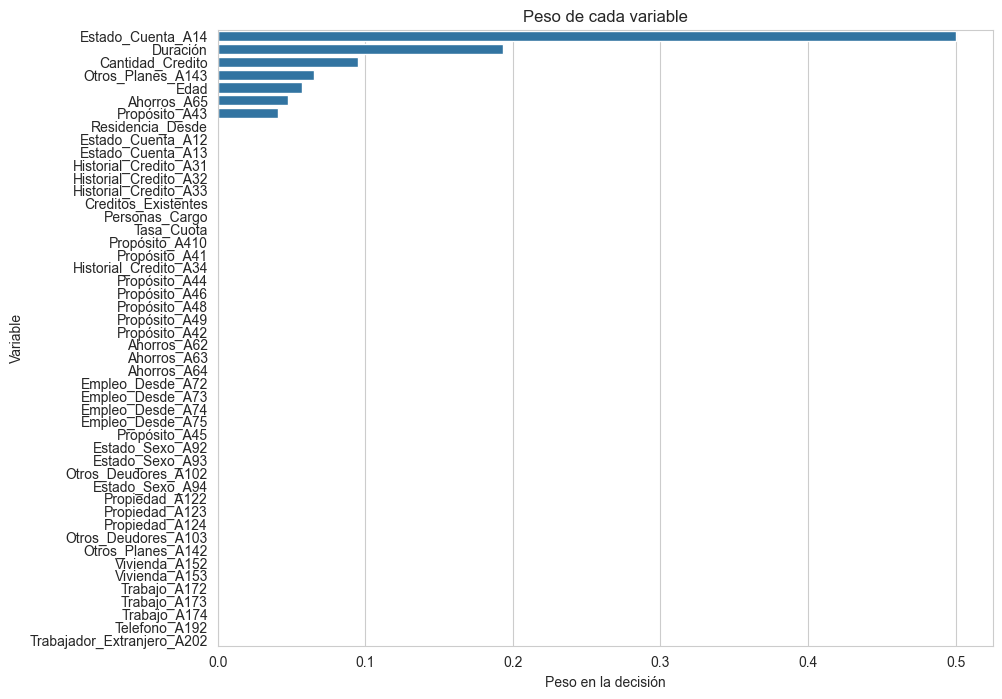

Variables más importantes:
             Variable  Importancia
9   Estado_Cuenta_A14     0.500047
0            Duración     0.193067
1    Cantidad_Credito     0.095383
40  Otros_Planes_A143     0.065167
4                Edad     0.057400


In [29]:
importancia = arbol.feature_importances_
nombres = X.columns

df_importancia = pd.DataFrame({'Variable': nombres, 'Importancia': importancia})
df_importancia = df_importancia.sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variable', data=df_importancia)
plt.title("Peso de cada variable")
plt.xlabel("Peso en la decisión")
plt.show()

print("Variables más importantes:")
print(df_importancia.head(5))

Analicemos qué significa el grafo obtenido. Primero fijémonos en los colores de los nodos finales (las hojas). Las cajas naranjas representan a los clientes clasificados como 'Buenos' y las azules a los 'Malos'. La intensidad del color nos indica la pureza del nodo: cuanto más oscuro, más seguro está el algoritmo de su decisión.

Primeramente, evaluando el nodo superior (la raíz), observamos que la variable discriminante principal es el Estado_Cuenta. El árbol separa drásticamente a los usuarios: hacia la derecha (False) van aquellos que no tienen cuenta corriente (categoría A14), y podemos ver que casi todas sus ramificaciones acaban en naranja. Esto nos indica que no tener una cuenta corriente registrada (o no usarla) es un fuerte indicador de ser buen pagador en este conjunto de datos.

Por el contrario, si nos vamos a la izquierda (True), entramos en el grupo de usuarios que sí tienen cuenta (probablemente con saldo deudor o bajo). Continuemos evaluando cómo interaccionan aquí la duración y la cantidad.

Podemos observar una estructura lógica, si el crédito tiene una Duración larga (mayor a 33 meses), la casilla se torna azul claro, indicando peligro. Además, si observamos la rama inferior izquierda, vemos que pedir una cantidad muy alta (superior a 10975) deriva en una casilla azul oscuro puro. Esto nos permite deducir un perfil de moroso claro: alguien con cuenta corriente activa que pide una cantidad excesiva de dinero.

Por último, evaluemos el lado derecho del árbol (los clientes seguros). Aquí el modelo utiliza variables como Otros_Planes_Cuotas y la Edad para refinar su decisión. A simple vista, se observa que, aunque este grupo es mayoritariamente bueno, los usuarios más jóvenes (Edad <= 23.5) presentan una tonalidad de naranja más suave, lo que sugiere un riesgo ligeramente superior al de los mayores.

Veamos como funciona esto sobre el conjunto de prueba.

In [30]:
y_pred = arbol.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Bueno (1)', 'Malo (2)']))


              precision    recall  f1-score   support

   Bueno (1)       0.74      0.95      0.83       209
    Malo (2)       0.65      0.22      0.33        91

    accuracy                           0.73       300
   macro avg       0.69      0.58      0.58       300
weighted avg       0.71      0.73      0.68       300



El parametro 'recall' es la capacidad de pillar fraudes y el parametro precisión es la capacidad de detectar falsos positivos.

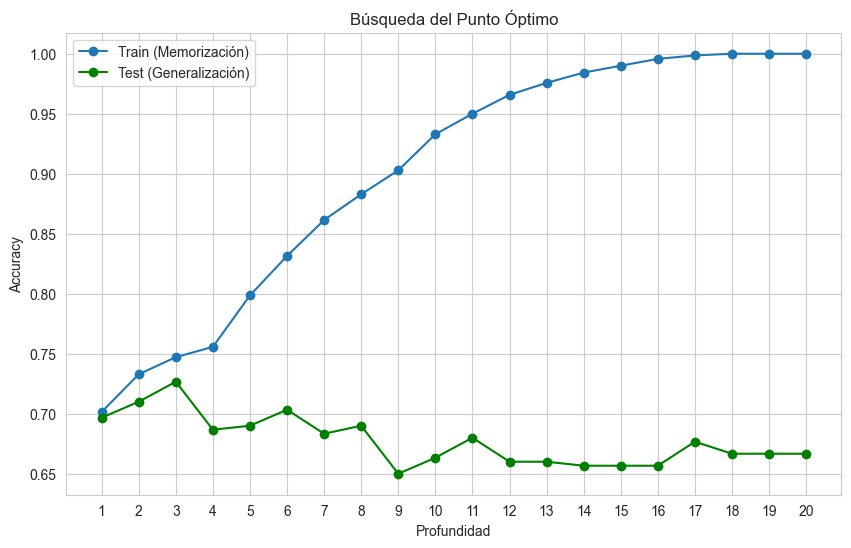

In [31]:
profundidades = range(1, 21)
notas_train = []
notas_test = []

for prof in profundidades:
    # IMPORTANTE: random_state=42 dentro del bucle para ser consistentes
    modelo = DecisionTreeClassifier(max_depth=prof, random_state=42)
    modelo.fit(X_train, y_train)
    notas_train.append(modelo.score(X_train, y_train))
    notas_test.append(modelo.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(profundidades, notas_train, marker='o', label='Train (Memorización)')
plt.plot(profundidades, notas_test, marker='o', color='green', label='Test (Generalización)')
plt.xlabel('Profundidad')
plt.ylabel('Accuracy')
plt.title('Búsqueda del Punto Óptimo')
plt.legend()
plt.xticks(profundidades)
plt.grid(True)
plt.show()

Tras observar que la optimización de la profundidad del árbol (max_depth=3) no era suficiente para capturar a los perfiles de riesgo, decidimos implementar una estrategia basada en el negocio.

Conceder un préstamo a un cliente que no pagará (Falso Positivo) es mucho más costoso (pérdida del capital) que denegar un préstamo a un buen cliente (pérdida de intereses). Siguiendo la documentación original del dataset, aplicamos una matriz de costes de 5 a 1.

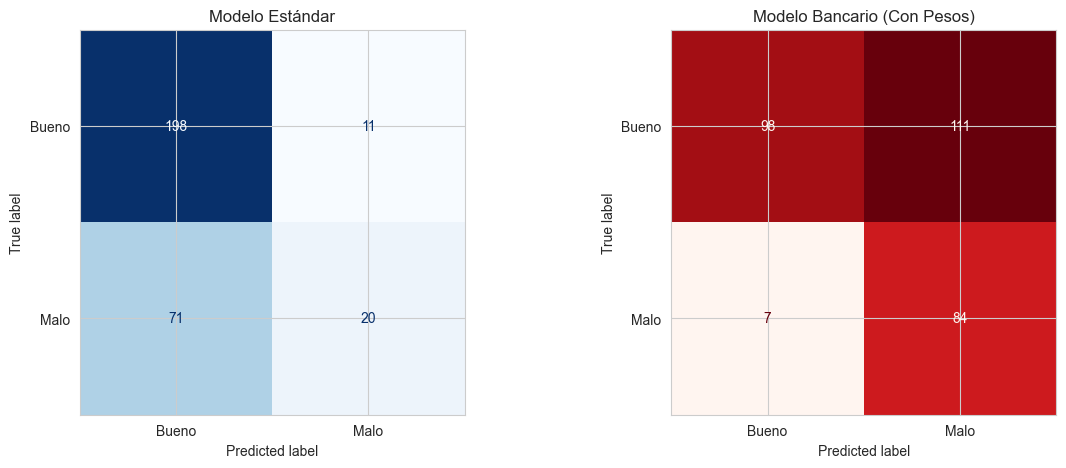

Total de Morosos reales en la muestra: 91
El Modelo Bancario detectó: 84 morosos.
El Modelo Estándar solo vio: 20 morosos.


In [32]:
pesos = {1: 1, 2: 5}
modelo_bancario = DecisionTreeClassifier(max_depth=3, class_weight=pesos, random_state=42)
modelo_bancario.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

cm_normal = confusion_matrix(y_test, arbol.predict(X_test))
ConfusionMatrixDisplay(cm_normal, display_labels=['Bueno', 'Malo']).plot(ax=ax[0], cmap='Blues', values_format='d', colorbar=False)
ax[0].set_title("Modelo Estándar")

cm_bancario = confusion_matrix(y_test, modelo_bancario.predict(X_test))
ConfusionMatrixDisplay(cm_bancario, display_labels=['Bueno', 'Malo']).plot(ax=ax[1], cmap='Reds', values_format='d', colorbar=False)
ax[1].set_title("Modelo Bancario (Con Pesos)")
plt.show()

morosos_detectados_normal = cm_normal[1, 1]
morosos_detectados_bancario = cm_bancario[1, 1]

print(f"Total de Morosos reales en la muestra: {cm_normal[1,0] + cm_normal[1,1]}")
print(f"El Modelo Bancario detectó: {morosos_detectados_bancario} morosos.")
print(f"El Modelo Estándar solo vio: {morosos_detectados_normal} morosos.")

En el Modelo Estándar, la casilla inferior izquierda tenía un valor muy alto (71 personas). Esto significa que el banco habría prestado dinero a 71 personas que no iban a devolverlo. En el Modelo Bancario, hemos logrado vaciar esta casilla (bajándola a 7), transfiriendo esos casos a la casilla de aciertos.
Además, el Modelo Bancario es 'paranoico' y rechaza a muchos clientes honestos simplemente porque se parecen un poco al perfil de un moroso. Desde el punto de vista de negocio, asumimos este sacrificio como nos ha sido indicado en el dataset.

In [33]:
print("\nMODELO NORMAL")

pred_normal = arbol.predict(X_test)
print(classification_report(y_test, pred_normal, target_names=['Bueno (1)', 'Malo (2)']))

print("\nMODELO BANCARIO")
pred_bancario = modelo_bancario.predict(X_test)
print(classification_report(y_test, pred_bancario, target_names=['Bueno (1)', 'Malo (2)']))


MODELO NORMAL
              precision    recall  f1-score   support

   Bueno (1)       0.74      0.95      0.83       209
    Malo (2)       0.65      0.22      0.33        91

    accuracy                           0.73       300
   macro avg       0.69      0.58      0.58       300
weighted avg       0.71      0.73      0.68       300


MODELO BANCARIO
              precision    recall  f1-score   support

   Bueno (1)       0.93      0.47      0.62       209
    Malo (2)       0.43      0.92      0.59        91

    accuracy                           0.61       300
   macro avg       0.68      0.70      0.61       300
weighted avg       0.78      0.61      0.61       300



Hacemos para finalizar un estudio en profundidad de los distintos hiperparámetros para detectar la mejor combinación posible. En este caso vemos que el modelo pierde capacidad de detección de fraude en favor de la precisión global, por lo que descartamos esa vía.
Utilizamos cv=5 significa que "Cross Validation": divide los datos en 5 trozos para validar mejor.

In [34]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10],           
    'min_samples_leaf': [1, 5, 10, 20, 50],       
    'criterion': ['gini', 'entropy'],              
    'class_weight': [None, {1:1, 2:5}]}         

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall_macro', #Buscamos optimizar el Recall (detectar fallos)
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(grid_search.best_params_)
print(f"\nMejor nota (Recall promedio) durante la validación: {grid_search.best_score_:.4f}")

mejor_modelo = grid_search.best_estimator_
print("\n--- RESULTADO FINAL EN TEST ---")
print(classification_report(y_test, mejor_modelo.predict(X_test)))

MEJOR COMBINACIÓN ENCONTRADA:
{'class_weight': {1: 1, 2: 5}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}

Mejor nota (Recall promedio) durante la validación: 0.6478

--- RESULTADO FINAL EN TEST ---
              precision    recall  f1-score   support

           1       0.78      0.67      0.72       209
           2       0.43      0.56      0.49        91

    accuracy                           0.64       300
   macro avg       0.60      0.62      0.60       300
weighted avg       0.67      0.64      0.65       300

